# Imports

In [ ]:
import torch
import torch.nn as nn
from google.colab import drive
from torchvision import models, transforms, datasets
import sys, os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [ ]:
dir = "/content/drive/MyDrive/SRC_HW2_E3/Encoder.pth"
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class Reshape(nn.Module):
  def __init__(self, *args):
      super().__init__()
      self.shape = args

  def forward(self, x):
      return x.view(self.shape)

class Trim(nn.Module):
  def __init__(self, *args):
      super().__init__()

  def forward(self, x):
      return x[:, :, :256, :]



class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.LeakyReLU(0.01),
        nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
        nn.Flatten(),
        nn.Linear(64*64*1, 2)
    )

  def forward(self, x):
      x = self.encoder(x)
      return x
    

encoder = Encoder()  
encoder.to(device)

Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4096, out_features=2, bias=True)
  )
)

In [ ]:
encoder = torch.load("/content/drive/MyDrive/SRC_HW2_E3/Encoder.pth", map_location=torch.device(device))
for param in encoder.parameters():
  param.requires_grad = False
encoder.eval()
encoder.double()

Encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=4096, out_features=2, bias=True)
  )
)

# Data Preprocessing

In [ ]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar

File ‘SEMG_DB1.rar’ already there; not retrieving.



In [ ]:
!unrar e  SEMG_DB1.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from SEMG_DB1.rar


Would you like to replace the existing file 10Amar.log
275168 bytes, modified on 2013-04-27 11:09
with a new one
275168 bytes, modified on 2013-04-27 11:09

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit E

Extracting  10Amar.txt                                                    23% 24%  OK 
Extracting  10Apie.txt                                                    24% 25%  OK 
Extracting  10Asen.txt                                                    25% 26%  OK 
Extracting  11Amar.txt                                                    26% 27%  OK 
Extracting  11Apie.txt                                                    27% 28%  OK 
Extracting  11Asen.txt                                                    28% 29%  OK 
Extracting  1Amar.txt                                                     30% 

In [ ]:
!mkdir data
!mkdir data/A
!mkdir data/N
!mv [1-9]A*.txt data/A
!mv [1-9]N*.txt data/N
!mv 1[0-9]A*.txt data/A
!mv 1[0-9]N*.txt data/N

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/A’: File exists
mkdir: cannot create directory ‘data/N’: File exists


In [ ]:
def read_folder(path): 
  folder_con = []
  file_name = []
  n = 1
  for file in os.listdir(path):
      if file.endswith(".txt"):
          file_path = f"{path}/{file}"
          df = pd.read_csv(file_path, sep='\t', skiprows=list(range(7)), header=None).dropna()
          
          if len(df.columns) == 6:
            df.drop(columns=df.columns[-2:], axis=1, inplace=True)
          if len(df.columns) == 5:
            df.drop(columns=df.columns[-1:], axis=1, inplace=True)
          
          folder_con.append(df)
          file_name.append(file_path)
          n = n + 1
          
  return folder_con, file_name

In [ ]:
A_folder_con, A_name = read_folder('data/A')
N_folder_con, N_name = read_folder('data/N')
A_final_data = pd.concat(A_folder_con, ignore_index=True)
N_final_data = pd.concat(N_folder_con, ignore_index=True)
A_torch_data = torch.tensor(A_final_data.values)
N_torch_data = torch.tensor(N_final_data.values)

In [ ]:
def image_creator(data, label, wid_len=256, stride=128):
  i = 0
  num = 0
  img_list = []
  while True:
    img = data[i: i+wid_len]
    i = i + stride
    num = num + 1 
    new = []
    new.append(img.reshape(1, wid_len, 4))
    new.append(label)
    img_list.append(new)
    if num == int(((len(data) - wid_len) / stride + 1)):
      break
  return img_list
  

In [ ]:
N_list = image_creator(N_torch_data, label=0, wid_len=256, stride=128)
A_list = image_creator(A_torch_data, label=1, wid_len=256, stride=128)
data = A_list + N_list

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data_frame = data
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data_frame[idx][0]
        image = image.double()
               
        label = self.data_frame[idx][1]
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train, test = train_test_split(data, test_size=0.33, shuffle=True)

In [ ]:
train_dataset = MyDataset(train)
test_dataset = MyDataset(test)



# Data loader
batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


# Network Implementation

In [ ]:
class Classifier(nn.Module):

  def __init__(self):
    super(Classifier, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(2, 2),
    )

  def forward(self, x):
    return self.layer1(x.double())

classifier = Classifier()
classifier = classifier.double()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters())

In [ ]:
def batch_gd(model, encoder, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  train_accs = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  test_accs = np.zeros(epochs)

  for it in range(epochs):
    n_correct = 0.
    n_total = 0.
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      encoded = encoder(inputs.double())
      outputs = model(encoded.double())
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())
      _, predictions = torch.max(outputs, 1)
      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]

    train_acc = n_correct / n_total
    train_loss = np.mean(train_loss)

    model.eval()
    with torch.no_grad():
      test_loss = []
      n_correct = 0.
      n_total = 0.
      for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        encoded = encoder(inputs)
        outputs = model(encoded.double())  
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
        _, predictions = torch.max(outputs, 1)
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

      test_loss = np.mean(test_loss)
      test_acc = n_correct / n_total

      train_losses[it] = train_loss
      test_losses[it] = test_loss
      train_accs[it] = train_acc
      test_accs[it] = test_acc


      dt = datetime.now() - t0
      print(f"Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration:{dt}")

  return train_losses, test_losses, train_accs, test_accs



# Model Train and Resualts

In [ ]:
train_losses, test_losses, train_accs, test_accs = batch_gd(
    classifier, encoder, criterion, optimizer, train_loader, test_loader, epochs=10
)

Epoch 1/10, Train Loss: 5.2086,       Test Loss: 4.2872, Duration:0:00:19.734172
Epoch 2/10, Train Loss: 3.4964,       Test Loss: 2.6234, Duration:0:00:17.680453
Epoch 3/10, Train Loss: 1.8865,       Test Loss: 1.1963, Duration:0:00:18.778758
Epoch 4/10, Train Loss: 0.8620,       Test Loss: 0.6760, Duration:0:00:18.965080
Epoch 5/10, Train Loss: 0.6582,       Test Loss: 0.6535, Duration:0:00:18.128332
Epoch 6/10, Train Loss: 0.6526,       Test Loss: 0.6533, Duration:0:00:18.274518
Epoch 7/10, Train Loss: 0.6489,       Test Loss: 0.6532, Duration:0:00:20.295306
Epoch 8/10, Train Loss: 0.6487,       Test Loss: 0.6533, Duration:0:00:18.316863
Epoch 9/10, Train Loss: 0.6544,       Test Loss: 0.6532, Duration:0:00:18.601101


In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
classifier.eval()
with torch.no_grad():
  n_correct = 0.
  n_total = 0.
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    encoded = encoder(inputs)
    outputs = classifier(encoded)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  train_acc = n_correct / n_total

  n_correct = 0.
  n_total = 0.
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    encoded = encoder(inputs)
    outputs = classifier(encoded)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  test_acc = n_correct / n_total
  print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.6427, Test acc: 0.6402


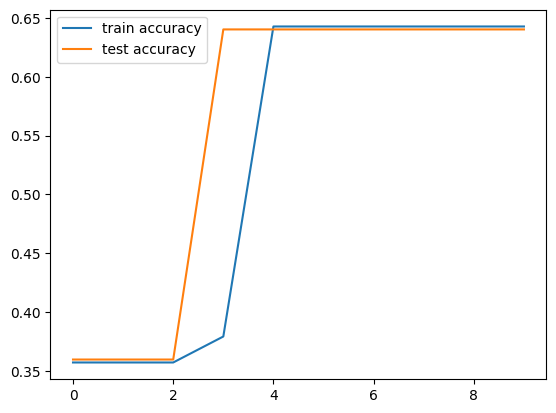

In [ ]:
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.show()